# Task 2 - Object localization

## Task 2.1 - Object Localization

### Task 2.1.1 - Loading the Datasets
We start by importing the packages we need. Then we load the data, and do a quick analysis length of them. Finally we normalize the data.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F
import numpy as np
from collections import Counter

torch.manual_seed(123)

#### Loading the datasets

In [4]:
localization_train = torch.load('../project02/localization_train.pt')
localization_val = torch.load('../project02/localization_val.pt')
localization_test = torch.load('../project02/localization_test.pt')

#### Some information about the dataset

In [5]:
print(len(localization_train))
print(len(localization_val))
print(len(localization_test))

59400
6600
11000


In [6]:
print("Shape of datasets' inputs: ", localization_train[:][0].size()[1:])
print("Shape of datasets' labels: ", localization_train[:][1].size()[1:])

Shape of datasets' inputs:  torch.Size([1, 48, 60])
Shape of datasets' labels:  torch.Size([6])


In [7]:
class_labels = localization_train[:][1][:,5]
print("Number of instances of each label (0-9):")
print(class_labels.unique(return_counts=True)[1]) 

Number of instances of each label (0-9):
tensor([ 5345, 11475,  5365,  5522,  5243,  4889,  5310,  5644,  5249,  5358])


We see that there are many instances of the class label 1. One can consider to remove some of these observations. Other than this, the dataset seems well balanced.  

Label 13 from the training dataset:  tensor([1.0000, 0.2333, 0.4792, 0.2000, 0.4167, 4.0000])


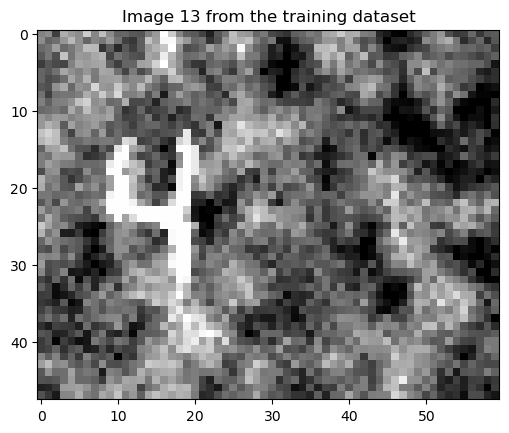

In [8]:
i = 12
img, label = localization_train[i]
fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')
plt.title(f"Image {i+1} from the training dataset")
plt.plot()
print(f"Label {i+1} from the training dataset: ", label)
#NOTE: imshow flips the dimensions x and y

#### Normalizing the data

In [9]:
imgs = torch.stack([img for img, _ in localization_train])

normalizer = transforms.Normalize(
                imgs.mean(dim=(0, 2, 3)), 
                imgs.std(dim=(0, 2, 3))  
             )

localization_train = [(normalizer(img), label) for img, label in localization_train]
localization_val = [(normalizer(img), label) for img, label in localization_val]
localization_test = [(normalizer(img), label) for img, label in localization_test]
print('Data is normalized')

Data is normalized


### Task 2.1.2 - Designing and Training Models

We start by defining a training loop function, and then the combined loss function. Then we define and train x models.

#### Training loop

In [10]:
def train(num_epochs, data_loader, model, optimizer, loss_fn):
    model.train()
    n_batch = len(data_loader)
    losses_train = []
    optimizer.zero_grad(set_to_none=True)
    
    for epoch in range(1, num_epochs+1):
    
        loss_train = 0

        for images, labels in data_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train += loss.item()

                
        losses_train.append(loss_train / n_batch)

        print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
        
    return losses_train

In [11]:
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.mse_loss = nn.MSELoss()
        
    def forward(self, outputs, labels):

        bce_loss = self.bce_loss(outputs[:,0], labels[:,0])
            
        for label in range(0,labels.size()[0]-1):
            if labels[:,0][label] == 1.0:
                mse_loss = self.mse_loss(outputs[:,1:5], labels[:,1:5]) 
                ce_loss = self.ce_loss(outputs[:,5:16], labels[:,5].long())
            else: 
                mse_loss = 0
                ce_loss = 0
        
        total_loss = bce_loss + mse_loss + ce_loss            
                                    
        return total_loss

#### Model 1

In [12]:
class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        # 3 sized channel hence the 3 sized krenel. Training on the gpu or using cuda
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(128 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        
        return x


In [13]:
torch.manual_seed(13)
train_loader = torch.utils.data.DataLoader(localization_train, batch_size=128, shuffle=True) 
loss_fn = CombinedLoss()
model1 = model1()
optimizer = optim.SGD(model1.parameters(), lr=0.1, momentum=0.6)

train(
    num_epochs = 21,
    optimizer = optimizer,
    model = model1,
    loss_fn = loss_fn,
    data_loader = train_loader,
)

18:09:04.386234  |  Epoch 1  |  Training loss 2.409


KeyboardInterrupt: 

#### Model 2

In [ ]:
class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        
        self.pool = nn.MaxPool2d(2, 2)  
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(32 * 22 * 28, 120)  
        self.fc2 = nn.Linear(120, 15)  
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = self.flat(x) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 

        return x

In [ ]:
torch.manual_seed(13)
train_loader = torch.utils.data.DataLoader(localization_train, batch_size=128, shuffle=True) 
loss_fn = CombinedLoss()
model2 = model2()
optimizer = optim.SGD(model2.parameters(), lr=0.1)

train(
    num_epochs = 21,
    optimizer = optimizer,
    model = model2,
    loss_fn = loss_fn,
    data_loader = train_loader,
)

10:33:47.521688  |  Epoch 1  |  Training loss 2.312
10:37:14.317180  |  Epoch 2  |  Training loss 1.719
10:40:29.130990  |  Epoch 3  |  Training loss 1.292
10:43:48.301693  |  Epoch 4  |  Training loss 0.979
10:47:08.612310  |  Epoch 5  |  Training loss 0.757
10:50:31.002252  |  Epoch 6  |  Training loss 0.545
10:53:48.464551  |  Epoch 7  |  Training loss 0.390
10:57:06.939874  |  Epoch 8  |  Training loss 0.259
11:00:26.107397  |  Epoch 9  |  Training loss 0.143
11:03:36.630423  |  Epoch 10  |  Training loss 0.077
11:06:44.579318  |  Epoch 11  |  Training loss 0.039
11:14:44.769733  |  Epoch 12  |  Training loss 0.026
11:18:11.988209  |  Epoch 13  |  Training loss 0.022
11:21:36.718131  |  Epoch 14  |  Training loss 0.019
11:24:56.667471  |  Epoch 15  |  Training loss 0.017
11:28:11.541689  |  Epoch 16  |  Training loss 0.014
11:31:25.693489  |  Epoch 17  |  Training loss 0.014
11:34:27.187925  |  Epoch 18  |  Training loss 0.012
11:37:19.606396  |  Epoch 19  |  Training loss 0.011
11

#### Model 3
Here, we will use the same architecture as in model 2, but add some L2 regularization to avoid what seems like overfitting in model 2.

In [ ]:
class model3(nn.Module):
    def __init__(self):
        super(model3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        
        self.pool = nn.MaxPool2d(2, 2)  
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(32 * 22 * 28, 120) 
        self.fc2 = nn.Linear(120, 15) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = self.flat(x) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  

        return x

In [ ]:
torch.manual_seed(13)
train_loader = torch.utils.data.DataLoader(localization_train, batch_size=128, shuffle=True) 
loss_fn = CombinedLoss()
model3 = model3()
optimizer = optim.SGD(model3.parameters(), lr=0.1, weight_decay=0.3)

train(
    num_epochs = 21,
    optimizer = optimizer,
    model = model3,
    loss_fn = loss_fn,
    data_loader = train_loader,
)
print('')

11:56:32.059820  |  Epoch 1  |  Training loss 2.527
11:59:15.793302  |  Epoch 2  |  Training loss 2.542
12:02:00.738851  |  Epoch 3  |  Training loss 2.512
12:04:54.737526  |  Epoch 4  |  Training loss 2.533
12:07:42.767713  |  Epoch 5  |  Training loss 2.556
12:10:31.642504  |  Epoch 6  |  Training loss 2.508
12:13:16.710421  |  Epoch 7  |  Training loss 2.527
12:16:03.135057  |  Epoch 8  |  Training loss 2.492
12:18:50.216021  |  Epoch 9  |  Training loss 2.593
12:21:37.421294  |  Epoch 10  |  Training loss 2.587
12:24:24.207649  |  Epoch 11  |  Training loss 2.521
12:27:11.888767  |  Epoch 12  |  Training loss 2.496
12:29:58.358299  |  Epoch 13  |  Training loss 2.536
12:32:45.106544  |  Epoch 14  |  Training loss 2.607
12:35:41.561887  |  Epoch 15  |  Training loss 2.577
12:38:33.102076  |  Epoch 16  |  Training loss 2.475
12:41:19.721773  |  Epoch 17  |  Training loss 2.552
12:44:10.521253  |  Epoch 18  |  Training loss 2.557
12:46:59.247943  |  Epoch 19  |  Training loss 2.533
12

[2.527435950406136,
 2.541723019717842,
 2.512498909267046,
 2.532762550730859,
 2.555777545802055,
 2.5077598051358296,
 2.5270692457434953,
 2.491910998154712,
 2.5933891601780408,
 2.586583052207065,
 2.52113233567566,
 2.4955681917487933,
 2.535846809514107,
 2.6073951245956524,
 2.577120669522593,
 2.475156189228899,
 2.5515436996054905,
 2.557499431185825,
 2.532988166200217,
 2.559960762691754,
 2.4716141561026213]

#### Model 4

In [ ]:
class model4(nn.Module):
    def __init__(self):
        super(model4, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)  
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)  
        
        self.pool = nn.MaxPool2d(2, 2)  
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(64 * 9 * 12, 120)  
        self.fc2 = nn.Linear(120, 15)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)  
        
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [ ]:
torch.manual_seed(13)
train_loader = torch.utils.data.DataLoader(localization_train, batch_size=128, shuffle=True) 
loss_fn = CombinedLoss()
model4 = model4()
optimizer = optim.SGD(model4.parameters(), lr=0.01)

train(
    num_epochs = 21,
    optimizer = optimizer,
    model = model4,
    loss_fn = loss_fn,
    data_loader = train_loader,
)
print('')

13:11:02.229362  |  Epoch 1  |  Training loss 2.508
13:13:21.775118  |  Epoch 2  |  Training loss 2.342
13:15:40.365829  |  Epoch 3  |  Training loss 2.180
13:18:13.362099  |  Epoch 4  |  Training loss 1.933
13:20:50.346727  |  Epoch 5  |  Training loss 1.826
13:23:17.076960  |  Epoch 6  |  Training loss 1.754
13:25:29.672882  |  Epoch 7  |  Training loss 1.676
13:27:39.362016  |  Epoch 8  |  Training loss 1.668
13:29:49.340755  |  Epoch 9  |  Training loss 1.563
13:32:01.805714  |  Epoch 10  |  Training loss 1.520
13:34:19.183908  |  Epoch 11  |  Training loss 1.478
13:36:39.207137  |  Epoch 12  |  Training loss 1.335
13:39:01.320514  |  Epoch 13  |  Training loss 1.230
13:41:21.152232  |  Epoch 14  |  Training loss 1.137
13:43:39.622851  |  Epoch 15  |  Training loss 1.067
13:45:58.146018  |  Epoch 16  |  Training loss 1.020
13:48:21.132018  |  Epoch 17  |  Training loss 0.980
13:50:43.026618  |  Epoch 18  |  Training loss 0.897
13:53:01.321650  |  Epoch 19  |  Training loss 0.869
13

In [ ]:
class model5(nn.Module):
    def __init__(self):
        super(model5, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.flat = nn.Flatten()

        
        self.fc1 = nn.Linear(64 * 8 * 11, 120)  
        self.fc2 = nn.Linear(120, 15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [ ]:
torch.manual_seed(13)
train_loader = torch.utils.data.DataLoader(localization_train, batch_size=128, shuffle=True) 
loss_fn = CombinedLoss()
model5 = model5()
optimizer = optim.SGD(model5.parameters(), lr=0.01)

train(
    num_epochs = 21,
    optimizer = optimizer,
    model = model5,
    loss_fn = loss_fn,
    data_loader = train_loader,
)
print('')

17:26:23.199270  |  Epoch 1  |  Training loss 2.519
17:29:06.048957  |  Epoch 2  |  Training loss 2.365
17:31:56.221638  |  Epoch 3  |  Training loss 2.158
17:34:45.866263  |  Epoch 4  |  Training loss 1.842
17:37:33.578140  |  Epoch 5  |  Training loss 1.806
17:40:18.645286  |  Epoch 6  |  Training loss 1.759
17:43:02.150224  |  Epoch 7  |  Training loss 1.723
17:45:48.024399  |  Epoch 8  |  Training loss 1.678
17:48:33.709925  |  Epoch 9  |  Training loss 1.555
17:51:17.334129  |  Epoch 10  |  Training loss 1.482
17:54:03.526182  |  Epoch 11  |  Training loss 1.340
17:56:48.552489  |  Epoch 12  |  Training loss 1.255
17:59:35.843241  |  Epoch 13  |  Training loss 1.198
18:02:19.146497  |  Epoch 14  |  Training loss 1.082
18:04:56.442609  |  Epoch 15  |  Training loss 1.015
18:07:37.018757  |  Epoch 16  |  Training loss 0.925
18:10:12.000069  |  Epoch 17  |  Training loss 0.913
18:12:53.524608  |  Epoch 18  |  Training loss 0.849
18:15:39.723554  |  Epoch 19  |  Training loss 0.802
18

In [ ]:
class model6(nn.Module):
    def __init__(self):
        super(model6, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)  
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)  

        self.pool = nn.MaxPool2d(2, 2)  
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(128 * 10 * 13, 512)
        self.fc2 = nn.Linear(512, 15)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [ ]:
torch.manual_seed(13)
train_loader = torch.utils.data.DataLoader(localization_train, batch_size=128, shuffle=True) 
loss_fn = CombinedLoss()
model6 = model6()
optimizer = optim.SGD(model6.parameters(), lr=0.01)

train(
    num_epochs = 21,
    optimizer = optimizer,
    model = model6,
    loss_fn = loss_fn,
    data_loader = train_loader,
)
print('')

09:34:53.720820  |  Epoch 1  |  Training loss 2.532
09:50:31.661156  |  Epoch 2  |  Training loss 2.415
10:06:09.701578  |  Epoch 3  |  Training loss 2.229
10:53:36.023156  |  Epoch 4  |  Training loss 1.851
11:07:19.571555  |  Epoch 5  |  Training loss 1.790
11:20:24.789229  |  Epoch 6  |  Training loss 1.713
11:33:22.220517  |  Epoch 7  |  Training loss 1.622
11:46:27.140231  |  Epoch 8  |  Training loss 1.538
11:59:20.943348  |  Epoch 9  |  Training loss 1.478
13:22:38.497028  |  Epoch 10  |  Training loss 1.463
13:36:28.003830  |  Epoch 11  |  Training loss 1.362
13:49:34.809032  |  Epoch 12  |  Training loss 1.292
14:02:54.234642  |  Epoch 13  |  Training loss 1.170
14:15:55.760502  |  Epoch 14  |  Training loss 1.054
14:29:02.273623  |  Epoch 15  |  Training loss 0.894
14:42:11.944149  |  Epoch 16  |  Training loss 0.829
14:55:06.326054  |  Epoch 17  |  Training loss 0.752
15:07:57.893622  |  Epoch 18  |  Training loss 0.701
15:20:41.615677  |  Epoch 19  |  Training loss 0.663
15

### Task 2.1.3 - Model Selection 

We start by defining a function that calculates intersection over union. Then we define a function compute_accuracy that calculates the IoU and the fraction of correct classification (the binary variable is the same for the prediction and true label, and eventually that the predicted class is correct.

In [ ]:
def bbox_iou(box1, box2):

    box1_x1 = box1[0] - box1[2] / 2 #top left x
    box1_y1 = box1[1] - box1[3] / 2 #top left y
    box1_x2 = box1[0] + box1[2] / 2 #bottom right x
    box1_y2 = box1[1] + box1[3] / 2 #bottom right y

    box2_x1 = box2[0] - box2[2] / 2 #top left x
    box2_y1 = box2[1] - box2[3] / 2 #top left y
    box2_x2 = box2[0] + box2[2] / 2 #bottom right x
    box2_y2 = box2[1] + box2[3] / 2 #bottom right y

    x_left = max(box1_x1, box2_x1) 
    y_top = max(box1_y1, box2_y1) 
    x_right = min(box1_x2, box2_x2)
    y_bottom = min(box1_y2, box2_y2)
    
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)
    
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    
    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area
    return iou


In [ ]:
def compute_accuracy(model, data_loader):
    model.eval()
    total_iou = 0
    correct_classifications = 0
    no_of_objects = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            
            outputs = model(imgs)
            batch_size = labels.size()[0]
            
            for i in range(0,batch_size-1):           
                if labels[:,0][i] > 0.5:
                    total_iou += bbox_iou(outputs[:,1:5][i], labels[:,1:5][i])
                    if outputs[:,0][i] > 0 and torch.argmax(outputs[:,5:16][i]) == labels[:,5][i].long():
                        correct_classifications += 1 
                else:
                    total_iou += 0
                    if outputs[:,0][i] < 0:
                        correct_classifications += 1

            no_of_objects += labels[:,0].sum()
                
            total += batch_size
            

    acc =  correct_classifications / total
    avg_iou = total_iou / no_of_objects
    
    return avg_iou, acc


#### Compute validation accuracy for the models

In [ ]:
print("-------")
print("MODEL 1")
print("-------")

val_loader = torch.utils.data.DataLoader(localization_val, batch_size=64, shuffle=False)
ioutest, acctest = compute_accuracy(model1, val_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 1
-------
Intersection over Union:  0.174
Accuracy:  0.64
Average of accuracy and IoU:  0.407


In [ ]:
print("-------")
print("MODEL 2")
print("-------")

val_loader = torch.utils.data.DataLoader(localization_val, batch_size=128, shuffle=False)
ioutest, acctest = compute_accuracy(model2, val_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 2
-------
Intersection over Union:  0.375
Accuracy:  0.736
Average of accuracy and IoU:  0.556


In [ ]:
print("-------")
print("MODEL 3")
print("-------")

val_loader = torch.utils.data.DataLoader(localization_val, batch_size=128, shuffle=False)
ioutest, acctest = compute_accuracy(model3, val_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 3
-------
Intersection over Union:  0.05
Accuracy:  0.1
Average of accuracy and IoU:  0.075


In [ ]:
print("-------")
print("MODEL 4")
print("-------")

val_loader = torch.utils.data.DataLoader(localization_val, batch_size=128, shuffle=False)
ioutest, acctest = compute_accuracy(model4, val_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 4
-------
Intersection over Union:  0.409
Accuracy:  0.684
Average of accuracy and IoU:  0.547


In [ ]:
print("-------")
print("MODEL 5")
print("-------")

val_loader = torch.utils.data.DataLoader(localization_val, batch_size=128, shuffle=False)
ioutest, acctest = compute_accuracy(model5, traintest_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 5
-------
Intersection over Union:  0.323
Accuracy:  0.567
Average of accuracy and IoU:  0.445


In [ ]:
print("-------")
print("MODEL 6")
print("-------")

val_loader = torch.utils.data.DataLoader(localization_val, batch_size=128, shuffle=False)
ioutest, acctest = compute_accuracy(model6, val_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 6
-------
Intersection over Union:  0.271
Accuracy:  0.719
Average of accuracy and IoU:  0.495


### Task 2.1.4 - Model Evaluation
Model 2 turned out to perform best on the validation set, and so we choose this.

In [ ]:
print("-------")
print("MODEL 2")
print("-------")

test_loader = torch.utils.data.DataLoader(localization_test, batch_size=128, shuffle=False)
ioutest, acctest = compute_accuracy(model2, test_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 2
-------
Intersection over Union:  0.372
Accuracy:  0.734
Average of accuracy and IoU:  0.553


### Task 2.1.5 - Plotting Some Images and Boxes
We start by predicting a single batch of the test data and store the output. Then we plot four images with true and predicted bounding boxes, as well as printing the true and predicted labels.

In [ ]:
small_loader = torch.utils.data.DataLoader(localization_test[0:64], batch_size=64, shuffle=False)
with torch.no_grad():
    for imgs, labels in small_loader:
        model2.eval()
        outputs = model2(imgs)
        true = labels

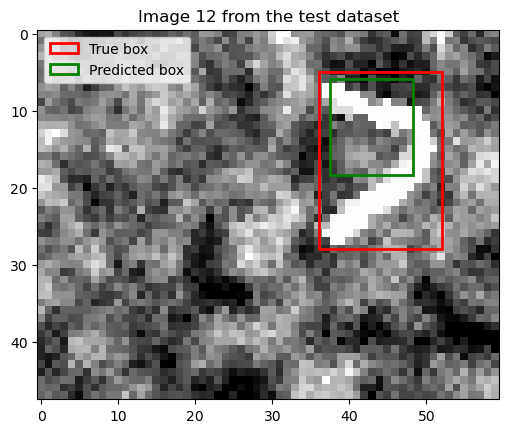

True label:  7
Predicted label:  7


In [ ]:
sample = 11
img, label = localization_test[sample]
true_box = label[1:5]
fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')    
# NOTE: imshow flips the dimensions, so that we need to multiply x with 60 and y with 48
true_rect = patches.Rectangle((60*(true_box[0]-true_box[2]/2), 48*(true_box[1]-true_box[3]/2)), 60*true_box[2], 48*true_box[3], linewidth = 2, edgecolor='r', facecolor='none', label = "True box")
pred = outputs[:,1:5][sample]
pred_rect = patches.Rectangle((60*(pred[0]-pred[2]/2), 48*(pred[1]-pred[3]/2)), 60*pred[2], 48*pred[3], linewidth=2, edgecolor='g', facecolor='none', label = "Predicted box")
ax.add_patch(true_rect)
ax.add_patch(pred_rect)
plt.legend(loc="upper left")
plt.title(f"Image {sample+1} from the test dataset")
plt.show()
print("True label: ", label[5].long().item())
print("Predicted label: ", torch.argmax(outputs[:,5:16][sample]).item())

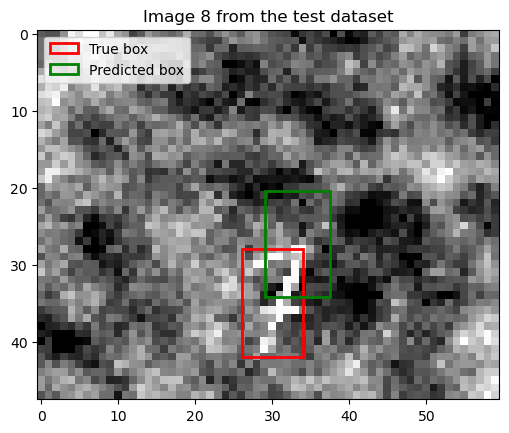

True label:  7
Predicted label:  2


In [ ]:
sample = 7
img, label = localization_test[sample]
true_box = label[1:5]
fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')     
# NOTE: imshow flips the dimensions, so that we need to multiply x with 60 and y with 48
true_rect = patches.Rectangle((60*(true_box[0]-true_box[2]/2), 48*(true_box[1]-true_box[3]/2)), 60*true_box[2], 48*true_box[3], linewidth = 2, edgecolor='r', facecolor='none', label = "True box")
pred = outputs[:,1:5][sample]
pred_rect = patches.Rectangle((60*(pred[0]-pred[2]/2), 48*(pred[1]-pred[3]/2)), 60*pred[2], 48*pred[3], linewidth=2, edgecolor='g', facecolor='none', label = "Predicted box")
ax.add_patch(true_rect)
ax.add_patch(pred_rect)
plt.legend(loc="upper left")
plt.title(f"Image {sample+1} from the test dataset")
plt.show()
print("True label: ", label[5].long().item())
print("Predicted label: ", torch.argmax(outputs[:,5:16][sample]).item())

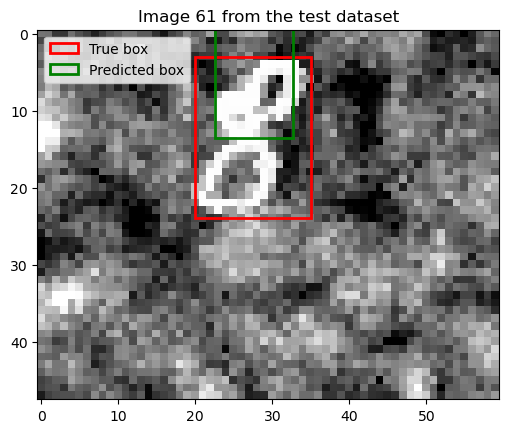

True label:  8
Predicted label:  8


In [ ]:
sample = 60
img, label = localization_test[sample]
true_box = label[1:5]
fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')   
# NOTE: imshow flips the dimensions, so that we need to multiply x with 60 and y with 48
true_rect = patches.Rectangle((60*(true_box[0]-true_box[2]/2), 48*(true_box[1]-true_box[3]/2)), 60*true_box[2], 48*true_box[3], linewidth = 2, edgecolor='r', facecolor='none', label = "True box")
pred = outputs[:,1:5][sample]
pred_rect = patches.Rectangle((60*(pred[0]-pred[2]/2), 48*(pred[1]-pred[3]/2)), 60*pred[2], 48*pred[3], linewidth=2, edgecolor='g', facecolor='none', label = "Predicted box")
ax.add_patch(true_rect)
ax.add_patch(pred_rect)
plt.legend(loc="upper left")
plt.title(f"Image {sample+1} from the test dataset")
plt.show()
print("True label: ", label[5].long().item())
print("Predicted label: ", torch.argmax(outputs[:,5:16][sample]).item())

# Task 3 - Object Detection

## Task 3.1.1 - Converting y_true_list to Tensor

### Task 3.1.1.1 - Loading the label lists 

In [ ]:
list_y_true_train = torch.load('../Project 2/list_y_true_train.pt')
list_y_true_val = torch.load('../Project 2/list_y_true_val.pt')
list_y_true_test = torch.load('../Project 2/list_y_true_test.pt')

### Task 3.1.1.2 & 3.1.1.3 - Converting the List to a Tensor
We start by writing a function that takes a list of labels, defines a zeros tensor of the right dimension, and replaces some of the zero subtensors in the tensor (the correct ones) with the tensors of the list. Then we check if the dimension corresponds to the labels in the provided datasets. Then we check if all the elements of the two correspond. To not get stuck in this task, we did task 3.1.2 before this one, and that is the reason that we have used the provided datasets and not the self-made one in task 3.1.2.    

In [ ]:
def convert_to_tensor(list_y_true):
    H_out = 2
    W_out = 3
    shape = (len(list_y_true), H_out, W_out, 6)
    y_true_tensor = torch.zeros(shape)

    for i in range(0, len(list_y_true)):
        for j in range (0, len(list_y_true[i])):
            if list_y_true[i][j][2] < 1/H_out:
                if list_y_true[i][j][1] < 1/W_out:
                    y_true_tensor[i,0,0,] = list_y_true[i][j] * torch.tensor([1, W_out, H_out, W_out, H_out, 1])
                elif list_y_true[i][j][1] >= 2/W_out:
                    y_true_tensor[i,0,2,] = (torch.tensor([0, -2/W_out, 0, 0, 0, 0]) + list_y_true[i][j]) * torch.tensor([1, W_out, H_out, W_out, H_out, 1])
                else:
                    y_true_tensor[i,0,1,] = (torch.tensor([0, -1/W_out, 0, 0, 0, 0]) + list_y_true[i][j]) * torch.tensor([1, W_out, H_out, W_out, H_out, 1])
            else:
                if list_y_true[i][j][1] < 1/W_out:
                    y_true_tensor[i,1,0,] = (torch.tensor([0, 0, -1/H_out, 0, 0, 0]) + list_y_true[i][j]) * torch.tensor([1, W_out, H_out, W_out, H_out, 1])
                elif list_y_true[i][j][1] >= 2/W_out:
                    y_true_tensor[i,1,2,] = (torch.tensor([0, -2/W_out, -1/H_out, 0, 0, 0]) + list_y_true[i][j]) * torch.tensor([1, W_out, H_out, W_out, H_out, 1])
                else:
                    y_true_tensor[i,1,1,] = (torch.tensor([0, -1/W_out, -1/H_out, 0, 0, 0]) + list_y_true[i][j]) * torch.tensor([1, W_out, H_out, W_out, H_out, 1])

    return y_true_tensor

In [ ]:
y_true_train = convert_to_tensor(list_y_true_train)
y_true_val = convert_to_tensor(list_y_true_val)
y_true_test = convert_to_tensor(list_y_true_test)

In [ ]:
print(y_true_train.size())
print(y_true_val.size())
print(y_true_test.size())

torch.Size([26874, 2, 3, 6])
torch.Size([2967, 2, 3, 6])
torch.Size([4981, 2, 3, 6])


We can see that the dimensions are okay. For safety, let's check if all the elements in the dataset labels are equal (the detection_xxx.pt datasets are already loaded).

In [ ]:
check_train = torch.where(y_true_train[:]==detection_train[:][1], 1, 0).sum()
if check_train == len(detection_train)*2*3*6:
    print("All elements in the two tensors are equal, good job")
else:
    print("Not all elements in the two tensors are equal, bad job")

All elements in the two tensors are equal, good job


In [ ]:
check_val = torch.where(y_true_val[:]==detection_val[:][1], 1, 0).sum()
if check_val == len(detection_val)*2*3*6:
    print("All elements in the two tensors are equal, good job")
else:
    print("Not all elements in the two tensors are equal, bad job")

All elements in the two tensors are equal, good job


In [ ]:
check_test = torch.where(y_true_test[:]==detection_test[:][1], 1, 0).sum()
if check_test == len(detection_test)*2*3*6:
    print("All elements in the two tensors are equal, good job")
else:
    print("Not all elements in the two tensors are equal, bad job")

All elements in the two tensors are equal, good job


## Task 3.1.2 - Object Detection Task

### Task 3.1.2.1 - Loading the Datasets

In [ ]:
detection_train = torch.load('../Project 2/detection_train.pt')
detection_val = torch.load('../Project 2/detection_val.pt')
detection_test = torch.load('../Project 2/detection_test.pt')

#### Some information about the datasets

In [ ]:
print(len(detection_train))
print(len(detection_val))
print(len(detection_test))

26874
2967
4981


In [ ]:
print("Shape of datasets' inputs: ", detection_train[:][0].size()[1:])
print("Shape of datasets' labels: ", detection_train[:][1].size()[1:])

Shape of datasets' inputs:  torch.Size([1, 48, 60])
Shape of datasets' labels:  torch.Size([2, 3, 6])


In [ ]:
labels = detection_train[:][1]
print("Number of instances of label 0: ", len(detection_train)-labels[:,:,:,5].sum().long().item())
print("Number of instances of label 1: ", labels[:,:,:,5].sum().long().item())

Number of instances of label 0:  8649
Number of instances of label 1:  18225


Label 19 from the training dataset: 
tensor([[[1.0000, 0.5500, 0.3750, 0.8000, 0.7500, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.2000, 0.8125, 0.1000, 0.5417, 1.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])


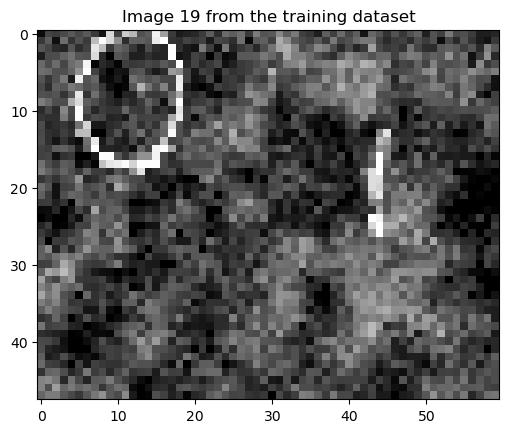

In [ ]:
i = 18
img, label = detection_train[i]
fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')
plt.title(f"Image {i+1} from the training dataset")
plt.plot()
print(f"Label {i+1} from the training dataset: ")
print(label)
#NOTE: imshow flips the dimensions x and y

#### Normalizing the data

In [ ]:
imgs = torch.stack([img for img, _ in localization_train])

normalizer = transforms.Normalize(
                imgs.mean(dim=(0, 2, 3)), 
                imgs.std(dim=(0, 2, 3))
            )

detection_train = [(normalizer(img), label) for img, label in detection_train]
detection_val = [(normalizer(img), label) for img, label in detection_val]
detection_test = [(normalizer(img), label) for img, label in detection_test]
print('Data is normalized')

Data is normalized


### Task 3.1.2.2 - Model Design
We start by redefining the loss function and training loop. Then we implement a model and train it. 

In [ ]:
def CombinedLoss(outputs, labels):
    
    bce_loss = nn.BCEWithLogitsLoss()
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()
    total_loss = 0
                    
    for l in range(0,labels.size()[0]-1):
        for w in range(0,2):
            for h in range(0,3):
                if labels[l, w, h, 0] == 1.0:
                    total_loss += bce_loss(outputs[l, w, h, 0], labels[l, w, h, 0])
                    total_loss += mse_loss(outputs[l, w, h, 1:5], labels[l, w, h, 1:5]) 
                    total_loss += ce_loss(outputs[l, w, h, 5:7], labels[l, w, h, 5].long())
                else: 
                    total_loss += bce_loss(outputs[l, w, h, 0], labels[l, w, h, 0])
                                            
    return total_loss

In [ ]:
def train(num_epochs, data_loader, model, optimizer, loss_fn):
    model.train()
    n_batch = len(data_loader)
    losses_train = []
    optimizer.zero_grad(set_to_none=True)
    
    for epoch in range(1, num_epochs+1):
    
        loss_train = 0

        for images, labels in data_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train += loss.item()

        losses_train.append(loss_train / n_batch*2*3)

        print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch*2*3))
        
    return losses_train

In [ ]:
class model_det(nn.Module):
    def __init__(self):
        super(model_det, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 5), stride=(6, 5), padding=(0, 0))
        self.conv4 = nn.Conv2d(64, 7, kernel_size=1) 

        self.relu = nn.ReLU()
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)  
        return x.permute(0, 2, 3, 1)  


In [ ]:
torch.manual_seed(13)
train_loader = torch.utils.data.DataLoader(detection_train, batch_size=64, shuffle=True) 
model_det = model_det()
optimizer = optim.SGD(model_det.parameters(), lr=0.001)

train(
    num_epochs = 21,
    optimizer = optimizer,
    model = model_det,
    loss_fn = CombinedLoss,
    data_loader = train_loader,
)
print('')

11:16:37.024700  |  Epoch 1  |  Training loss 173.989
11:18:34.961818  |  Epoch 2  |  Training loss 96.048
11:20:35.543356  |  Epoch 3  |  Training loss 82.121
11:22:34.724510  |  Epoch 4  |  Training loss 74.731
11:24:33.801509  |  Epoch 5  |  Training loss 70.196
11:26:45.352492  |  Epoch 6  |  Training loss 67.059
11:28:51.441008  |  Epoch 7  |  Training loss 64.843
11:30:55.506293  |  Epoch 8  |  Training loss 63.078
11:33:04.643148  |  Epoch 9  |  Training loss 61.874
11:35:10.971391  |  Epoch 10  |  Training loss 60.606
11:37:20.200548  |  Epoch 11  |  Training loss 59.506
11:39:21.230828  |  Epoch 12  |  Training loss 58.653
11:41:10.973423  |  Epoch 13  |  Training loss 58.060
11:43:10.485731  |  Epoch 14  |  Training loss 57.122
11:45:09.691540  |  Epoch 15  |  Training loss 56.451
11:47:02.821587  |  Epoch 16  |  Training loss 56.001
11:48:52.902977  |  Epoch 17  |  Training loss 55.417
11:50:40.792387  |  Epoch 18  |  Training loss 54.726
11:52:23.350610  |  Epoch 19  |  Tra

### Task 3.1.2.3 - Training Several Models

In [ ]:
class model_det2(nn.Module):
    def __init__(self):
        super(model_det2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 7, kernel_size=1) 
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 2), stride=(3, 2))  

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool1(self.relu(self.conv2(x)))
        x = self.pool1(self.relu(self.conv3(x)))
        x = self.pool2(self.relu(self.conv4(x)))
        x = self.conv5(x)  
        return x.permute(0, 2, 3, 1)  


In [ ]:
torch.manual_seed(13)
train_loader = torch.utils.data.DataLoader(detection_train, batch_size=64, shuffle=True) 
model_det2 = model_det2()
optimizer = optim.SGD(model_det2.parameters(), lr=0.001)

train(
    num_epochs = 21,
    optimizer = optimizer,
    model = model_det2,
    loss_fn = CombinedLoss,
    data_loader = train_loader,
)
print('')

17:24:49.405064  |  Epoch 1  |  Training loss 127.399
17:29:44.767536  |  Epoch 2  |  Training loss 37.555
17:34:53.471335  |  Epoch 3  |  Training loss 24.276
17:39:57.024432  |  Epoch 4  |  Training loss 20.625
17:44:41.103012  |  Epoch 5  |  Training loss 18.196
17:48:44.935509  |  Epoch 6  |  Training loss 16.949
17:53:05.874162  |  Epoch 7  |  Training loss 15.529
17:57:19.096192  |  Epoch 8  |  Training loss 14.641
18:01:29.021227  |  Epoch 9  |  Training loss 13.597
18:05:41.209338  |  Epoch 10  |  Training loss 12.918
18:09:57.326294  |  Epoch 11  |  Training loss 11.964
18:26:36.800390  |  Epoch 12  |  Training loss 11.218
18:31:20.742793  |  Epoch 13  |  Training loss 10.669
18:36:00.388530  |  Epoch 14  |  Training loss 9.954
18:40:52.378110  |  Epoch 15  |  Training loss 9.640
21:59:57.036808  |  Epoch 16  |  Training loss 8.590
22:04:55.621149  |  Epoch 17  |  Training loss 8.104
22:09:50.687994  |  Epoch 18  |  Training loss 7.820
22:14:32.182602  |  Epoch 19  |  Training

### Task 3.1.2.4 - Model Selection

In [ ]:
def compute_accuracy(model, data_loader):
    model.eval()
    total_iou = 0
    correct_classifications = 0
    no_of_objects = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            
            outputs = model(imgs)
            batch_size = labels.size()[0]
            
            for l in range(0,batch_size-1):
                for h in range(0,2):
                    for w in range(0,3): 
                        if labels[l, h, w, 0] == 1.0:
                            if outputs[l, h, w, 0] > 0:
                                total_iou += bbox_iou(outputs[l, h, w, 1:5], labels[l, h, w, 1:5])
                                if torch.argmax(outputs[l, h, w, 5:7]) == labels[l, h, w, 5]:
                                    correct_classifications += 1
                        else:
                            total_iou += 0
                            if outputs[l, h, w, 0] < 0:
                                correct_classifications += 1
                
                no_of_objects += labels[l][:,:,0].sum()

            total += batch_size

    acc =  correct_classifications / (2*3*total)
    avg_iou = total_iou / no_of_objects
    
    return avg_iou, acc

In [ ]:
print("-------")
print("MODEL 1")
print("-------")

val_loader = torch.utils.data.DataLoader(detection_val, batch_size=64, shuffle=False)
ioutest, acctest = compute_accuracy(model_det, val_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 1
-------
Intersection over Union:  0.511
Accuracy:  0.935
Average of accuracy and IoU:  0.723


In [ ]:
print("-------")
print("MODEL 2")
print("-------")

val_loader = torch.utils.data.DataLoader(detection_val, batch_size=64, shuffle=False)
ioutest, acctest = compute_accuracy(model_det2, val_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 2
-------
Intersection over Union:  0.659
Accuracy:  0.968
Average of accuracy and IoU:  0.814


### Task 3.2.1.5 - Model Evaluation
Model 2 performed the best on the validation set, and thus we chose this model.

In [ ]:
print("-------")
print("MODEL 2")
print("-------")

test_loader = torch.utils.data.DataLoader(detection_test, batch_size=64, shuffle=False)
ioutest, acctest = compute_accuracy(model_det2, test_loader)

print("Intersection over Union: ", round(float(ioutest), 3))
print("Accuracy: ", round(float(acctest), 3))
print("Average of accuracy and IoU: ", round(float(0.5*ioutest+0.5*acctest), 3))

-------
MODEL 2
-------
Intersection over Union:  0.655
Accuracy:  0.968
Average of accuracy and IoU:  0.811


### Task 3.2.1.6 - Plotting Some Images and Boxes
We start by predicting a single batch of the test data and store the output. Then we plot four images with true and predicted bounding boxes, as well as printing the true and predicted labels.

In [ ]:
loader = torch.utils.data.DataLoader(detection_test, batch_size=64, shuffle=False)
with torch.no_grad():
    for imgs, labels in loader:
        model_det2.eval()
        outputs = model_det2(imgs)

True label:  0
Predicted label:  1
True label:  1
Predicted label:  0
True label:  0
Predicted label:  1


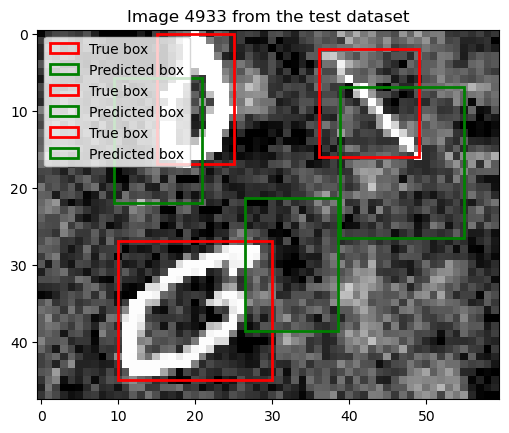

In [ ]:
sample = 5
img, label = detection_test[sample]
pred = outputs[sample]

fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')

for h in range(0,2):
    for w in range(0,3): 
        if label[h, w, 0] == 1.0:  
            true_rect = torch.tensor([20*w, 24*h, 0, 0]) + label[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            true_rect =  patches.Rectangle((true_rect[0]-true_rect[2]/2, true_rect[1]-true_rect[3]/2), true_rect[2], true_rect[3], linewidth = 2, edgecolor='r', facecolor='none', label = "True box")
            ax.add_patch(true_rect)
            
            pred_rect = torch.tensor([20*w, 24*h, 0, 0]) + pred[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            pred_rect =  patches.Rectangle((pred_rect[0]-pred_rect[2]/2, pred_rect[1]-pred_rect[3]/2), pred_rect[2], pred_rect[3], linewidth = 2, edgecolor='g', facecolor='none', label = "Predicted box")
            ax.add_patch(pred_rect)
            
            print(f"True label: ", label[h, w, 5].long().item())
            print(f"Predicted label: ", torch.argmax(pred[h, w, 5:7]).item())

plt.legend(loc="upper left")
plt.title(f"Image {len(detection_test)-outputs.size()[0]+sample+1} from the test dataset")
plt.show()

True label:  1
Predicted label:  1
True label:  1
Predicted label:  0


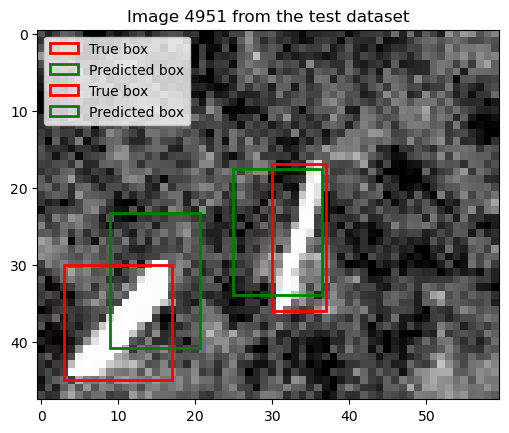

In [ ]:
sample = 23
img, label = detection_test[sample]
pred = outputs[sample]

fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')

for h in range(0,2):
    for w in range(0,3): 
        if label[h, w, 0] == 1.0:  
            true_rect = torch.tensor([20*w, 24*h, 0, 0]) + label[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            true_rect =  patches.Rectangle((true_rect[0]-true_rect[2]/2, true_rect[1]-true_rect[3]/2), true_rect[2], true_rect[3], linewidth = 2, edgecolor='r', facecolor='none', label = "True box")
            ax.add_patch(true_rect)
            
            pred_rect = torch.tensor([20*w, 24*h, 0, 0]) + pred[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            pred_rect =  patches.Rectangle((pred_rect[0]-pred_rect[2]/2, pred_rect[1]-pred_rect[3]/2), pred_rect[2], pred_rect[3], linewidth = 2, edgecolor='g', facecolor='none', label = "Predicted box")
            ax.add_patch(pred_rect)
            
            print(f"True label: ", label[h, w, 5].long().item())
            print(f"Predicted label: ", torch.argmax(pred[h, w, 5:7]).item())

plt.legend(loc="upper left")
plt.title(f"Image {len(detection_test)-outputs.size()[0]+sample+1} from the test dataset")
plt.show()

True label:  0
Predicted label:  1
True label:  1
Predicted label:  1


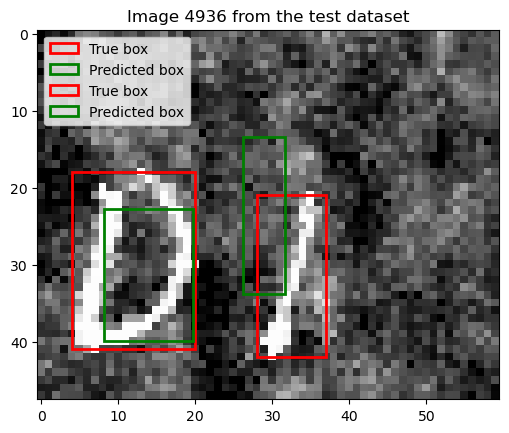

In [ ]:
sample = 7
img, label = detection_test[sample]
pred = outputs[sample]

fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')

for h in range(0,2):
    for w in range(0,3): 
        if label[h, w, 0] == 1.0:  
            true_rect = torch.tensor([20*w, 24*h, 0, 0]) + label[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            true_rect =  patches.Rectangle((true_rect[0]-true_rect[2]/2, true_rect[1]-true_rect[3]/2), true_rect[2], true_rect[3], linewidth = 2, edgecolor='r', facecolor='none', label = "True box")
            ax.add_patch(true_rect)
            
            pred_rect = torch.tensor([20*w, 24*h, 0, 0]) + pred[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            pred_rect =  patches.Rectangle((pred_rect[0]-pred_rect[2]/2, pred_rect[1]-pred_rect[3]/2), pred_rect[2], pred_rect[3], linewidth = 2, edgecolor='g', facecolor='none', label = "Predicted box")
            ax.add_patch(pred_rect)
            
            print(f"True label: ", label[h, w, 5].long().item())
            print(f"Predicted label: ", torch.argmax(pred[h, w, 5:7]).item())

plt.legend(loc="upper left")
plt.title(f"Image {len(detection_test)-outputs.size()[0]+sample+1} from the test dataset")
plt.show()

True label:  1
Predicted label:  0


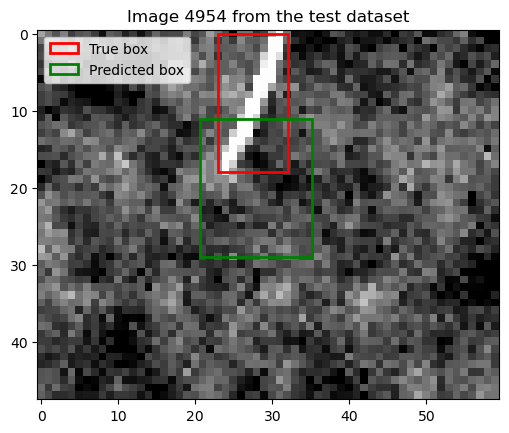

In [ ]:
sample = 25
img, label = detection_test[sample]
pred = outputs[sample]

fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')

for h in range(0,2):
    for w in range(0,3): 
        if label[h, w, 0] == 1.0:  
            true_rect = torch.tensor([20*w, 24*h, 0, 0]) + label[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            true_rect =  patches.Rectangle((true_rect[0]-true_rect[2]/2, true_rect[1]-true_rect[3]/2), true_rect[2], true_rect[3], linewidth = 2, edgecolor='r', facecolor='none', label = "True box")
            ax.add_patch(true_rect)
            
            pred_rect = torch.tensor([20*w, 24*h, 0, 0]) + pred[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            pred_rect =  patches.Rectangle((pred_rect[0]-pred_rect[2]/2, pred_rect[1]-pred_rect[3]/2), pred_rect[2], pred_rect[3], linewidth = 2, edgecolor='g', facecolor='none', label = "Predicted box")
            ax.add_patch(pred_rect)
            
            print(f"True label: ", label[h, w, 5].long().item())
            print(f"Predicted label: ", torch.argmax(pred[h, w, 5:7]).item())

plt.legend(loc="upper left")
plt.title(f"Image {len(detection_test)-outputs.size()[0]+sample+1} from the test dataset")
plt.show()

True label:  0
Predicted label:  1
True label:  1
Predicted label:  1


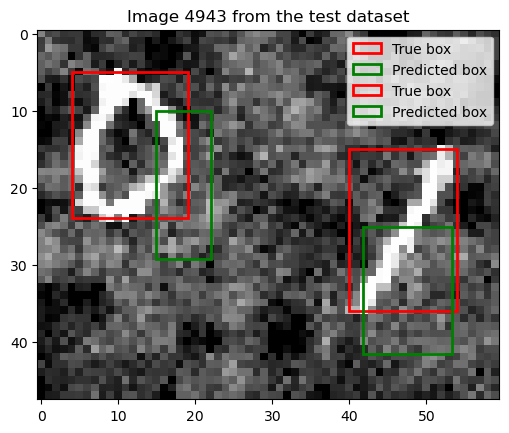

In [ ]:
sample = 14
img, label = detection_test[sample]
pred = outputs[sample]

fig, ax = plt.subplots()
img_as_array = np.array(img)  
img = img_as_array.squeeze()
ax.imshow(img, cmap='gray')

for h in range(0,2):
    for w in range(0,3): 
        if label[h, w, 0] == 1.0:  
            true_rect = torch.tensor([20*w, 24*h, 0, 0]) + label[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            true_rect =  patches.Rectangle((true_rect[0]-true_rect[2]/2, true_rect[1]-true_rect[3]/2), true_rect[2], true_rect[3], linewidth = 2, edgecolor='r', facecolor='none', label = "True box")
            ax.add_patch(true_rect)
            
            pred_rect = torch.tensor([20*w, 24*h, 0, 0]) + pred[h, w, 1:5] * torch.tensor([20, 24, 20, 24])
            pred_rect =  patches.Rectangle((pred_rect[0]-pred_rect[2]/2, pred_rect[1]-pred_rect[3]/2), pred_rect[2], pred_rect[3], linewidth = 2, edgecolor='g', facecolor='none', label = "Predicted box")
            ax.add_patch(pred_rect)
            
            print(f"True label: ", label[h, w, 5].long().item())
            print(f"Predicted label: ", torch.argmax(pred[h, w, 5:7]).item())

plt.legend(loc="upper right")
plt.title(f"Image {len(detection_test)-outputs.size()[0]+sample+1} from the test dataset")
plt.show()